In [1]:
import pandas as pd
import requests
import re

# Lab Notebook Transcript Varianst
- started with analysis of 3 GPCRs ADGRA1-3
- analyzation of several RNA-seq datasets from several tissues in order to extract a repertoire of all aGPCRs

Authors: Torsten and Moi

## Version informations
R = 3.6.1 <br>
ballgown = 2.18.0 <br>
via conda activate newStaroldStrigtie <br>

STAR = 2.7.6a <br> 
samtools = 1.9 <br>
StringTie = v2.1.3b <br>

## Emails

**2022-05-20**
Von: Sofie Otzen Bagger <sob@sund.ku.dk>
Gesendet: Freitag, 20. Mai 2022 08:18
An: Schöneberg, Torsten

We have found a short transcript variant to be rather active in our signalling assays, and of course we are very interested in the biological relevance of this variant. Thus, my question is if you would still be interested in looking into the penetrance of the various GPR123 variants in the human brain (you did already look into our choroid plexus RNA seq data for GPR124 and GPR125 -and GPR123 which is not very highly expressed there).
 
I have been trawling the GEO database for suitable RNAseq datasets published by other groups and the below listed are the ones that I think makes sense from a biological point of view (based on the expression of GPR123 eg in the cortex and hippocampus). However, my RNAseq –  and bioinformatics knowledge is not good enough for me to tell if the sequencing is deep enough for your analysis. Perhaps you will be willing to take a look at them and tell if it is even usable for you from a technical point of view? 
GEO accession numbers:
 
GSE178175 <br>
GSE182321 <br>
GSE173955 <br>
 
Von: Torsten
An: Susi und mich

ein enormer Bedarf nach möglichen Splice/Transcript Varianten im aGPCR zu schauen und diese zu Katalogisieren, ähnlich wie wir das mal für die mouse aGPCR (Alex Knierim) gemacht habe. Das wäre echt ein wertvolles und gutes Projekt mit einer hohen Schar von Anwendern und ein schönes Paper " The repertoire of transcript variants of adhesion GPCR de novo assembled from deep-sequenced human samples"
Konkret möchte diese Gruppe aus GSE182321 und GSE173955 dies für die Adhesion GPCR ADGRA1-3 (GPR123-125) haben. GSE178175 is snRNA-Seq und sehr wahrscheinlich zu low covered. Könnt ihr da mal reinschauen ob ein de novo möglich ist?
Lass mich mal bitte wissen was Du denkst - Danke und LG Dein Torsten

Von: Susi
An: mich und Torsten

Für GSE173955 gibt es zudem mglw. die Rohdaten frei in einem SRA Projekt: SRP318632


**2022-08-12**

Ich hatte eine Liste gestartet mit zu prozessierenden Datensätzen von verschiedenen Projekten. Mglw. kannst du die SRA für das brain transcripts Projekt vorbereiten. Ein tief-sequenziertes Vergleichsgewebe wäre noch gut, wo auch das Mumps-Virus infiziert aber nicht den primären Phänotyp macht, z.B. Leber. 

**2022-11-09** Emails mit Torsten

# 2022-05-24  first try - Transcript variants GPCR123

### GPCR123 - GPCR125

Ensemble:

ADGRA1 gene Chr10
- 2 splice variants 
- important role in the transduction of neural signals

ADGRA2 gene Chr8
- 3 splice variants

ADGRA3 gene Chr4
- 13 splice variants

In Cancer:
- Aberrant expression, function, and mutation of G protein-coupled receptors (GPCRs) and their signaling partners, G proteins, have been well documented in many forms of cancer. 

### Data 

GSE182321_OpiodUseDisorder_braintissues: 
- BioProject PRJNA755746; SRP332964; 41 samples 41 runs
- RNA sequencing analysis of postmortem human Brodmann Area 9 in the University of Texas Health Science Center at Houston Brain Collection
- Opiod Use Disorder
- Raw_count_matrix.csv
- sequencing depth: 20 -30 Million reads per sample
- 27 opioid users and 14 nonpsychiatric controls as determined by postmortem consensus diagnosis of 2 trained psychiatrists

GSE173955_Alzeihmer_braintissue:
- BioProject PRJNA727602; SRP318632; 18 samples 40 runs 
- Alzheimer
- We analyzed postmortem human hippocampus brains from 8 AD and 10 non-AD subjects using Illumina TruSeq stranded mRNA LT Sample Prep kit. Sequences were obtained by using HiSeq1500. One AD and one non-AD sample applied two independent times to sequencer in order to obtain more reads.
- sequencing depth: 30 -50 Million reads per sample
- 8 AD and 10 non-AD subjects

GSE174478 
- nonalcoholic fatty liver disease cohort
- PRJNA730024, SRP319881, 94 runs 



#### Download

download: 
didnt worked yet with prefetch and fastq-dump - i dont understand why

worked:
```shell
#!/usr/bin/bash

wget https://sra-pub-run-odp.s3.amazonaws.com/sra/$1/$1 -O $1.sra
fastq-dump --split-3 $1.sra
```
```cat SRR_list.txt | xargs -n 1 bash get_SRR_data.sh```

### Analysis

which mapper and quantification tools?
- HISAT2 and stringtie?
- altes Skript von Alex wieder verwenden? 
- cufflinks oder scripture sind "mapping first", 
- trinity, ABySS, SOAPdenovo, Oases sind "assembly first"

```
--quantMode GeneCounts 
--outSAMstrandField intronMotif
```

Aim: Stringtie mapping and subsequent assembly Not Trinity!, de novo assembly is without genome guidance refseq. Assembly of the genome would be tricky from RNAseq data! We don’t do this.

Potentieller Ablauf?
- fastqc
- trommomatic
- hisat2
- stringtie

https://nbisweden.github.io/workshop-RNAseq/1906/lab_assembly.html#2_guided_assembly



### Mapping and Quantification

**2022-10-05**

altes skript von alex c_elegans projekt verwenden <br>
Sein Paper: https://pubmed.ncbi.nlm.nih.gov/31363148

https://github.com/chrissikath/C.Elegans/blob/main/20211022_EasySpliceVariantAnalyses/splice_variants_analysis.sh

splice-variant-analysis.sh 
- umschreiben
- genome "/opt/genomes/human/hg38/ncbi_full_analysis_set/"

**STARINDEX**

- nur mit /opt/genomes/human/hg38/ncbi_full_analysis_set/STAR hat nicht geklappt
- eigenen index erstellen
    - eigenen - sjdbOverhang 100 -- genomeSAindexNbases 12;
    - GSE173955_Alzheimer -> read length 101
    - GSE182321_OpiodUseDisorder_braintissues -> 150
    - but mostly not ideal sjdb leads to marginal changes
    - genomeSAindexNbases g. Typically between 10 and 15.
    - Longer strings will use much more memory, but allow faster searches.
    
- genome/fasta musste erst unzipped werden -> gunzip -c GCA_000001405.15_GRCh38_full_analysis_set.fna.gz > /home/christina/Transcript_Variants_aGPCR/analysis/hg38.fna

**MAPPING**
- i used default STAR parameters 
- Paper: https://www.nature.com/articles/s41467-020-20573-7#Sec9
    - twopassMode=Basic could also be an option
    - with a minimal chimeric segment length of 20 or chimSegmentMin
    
**QUANTIFICATION**
- c -> minimum read coverage 
- f -> disable trimming at the end of the transcripts 
- m  -> minimum length allowed for the predicted transcripts (normal=200)
- a -> filtered out junctions that dont have spliced reads align with at least 1
- p -> number of processing threads ;

### Next steps

**2022-10-05**

**MERGEN GTFs**

--merge	Transcript merge mode

- StringTie takes as input a list of GTF/GFF files and merges/assembles these transcripts into a non-redundant set of transcripts
- generate a global, unified set of transcripts (isoforms) across multiple RNA-Seq samples.
- If the -G option (reference annotation) is provided, StringTie will assemble the transfrags from the input GTF files with the reference transcripts.
- Output is a merged GTF file with all merged gene models, but without any numeric results on coverage, FPKM, and TPM
- Then, with this merged GTF, StringTie can re-estimate abundances by running it again with the -e option on the original set of alignment files, as illustrated in the figure below.

**expression estimation mode** 

stringtie -e -B -G 
- The -e option is not required but recommended for this run in order to produce more accurate abundance estimations of the input transcripts
- will take as input the sorted read alignments (BAM file) obtained in step 1 for the corresponding sample and the -G option with the merged transcripts (GTF file) generated by stringtie --merge 

**gffcompare**

gffcompare –G –r genome.gtf merged.gtf



### All gtf zsm mergen um gleiche Transcripte zu bekommen

**2022-10-10**
```
OUTPUT="/home/christina/Transcript_Variants_aGPCR/analysis/GSE174478_Non_alcoholic_fatty_liver"
ls ${OUTPUT}/stringtie/*.gtf >> mergefile.txt

OUTPUT="/home/christina/Transcript_Variants_aGPCR/analysis/GSE173955_Alzheimer"
ls ${OUTPUT}/stringtie/*.gtf >> mergefile.txt

OUTPUT="/home/christina/Transcript_Variants_aGPCR/analysis/GSE182321_OpiodUseDisorder"
ls ${OUTPUT}/stringtie/*.gtf >> mergefile.txt

stringtie --merge -G $ANNO -o /home/christina/Transcript_Variants_aGPCR/analysis/combo.gtf mergefile.txt;
```

manche snRNA haben nicht geklappt:
- SRR14808724
- SRR14808725

-> nochmal laufen lassen 
-> nochmal alle mappen 

**2022-10-11**

ohne snRNA laufen lassen -> analyis/combo.gtf <br>
analysis/stringtie_expression_estimation.sh 

## Results

### Transkripte im Combo File

In [83]:
def transform_dataframe(dataframe):
    df_new = dataframe.join(dataframe['attributes'].str.split(';', 3, expand=True))
    columns=["type","start","stop", "attributes" ,"gene_id","transcript_id","gene_name","ref_gene_id"]
    df_new.set_axis(columns, axis=1,inplace=True)
    dataframe = df_new.drop(columns=["attributes"])
    return dataframe

**Für die drei GPCR Transkripte aus combo raussuchen**
grep "adgra1" -> gene_id = "MSTRG.8029"
grep "adgra2" -> gene_id = "MSTRG.52975"
grep "adgra3" -> gene_id = "MSTRG.39921"

```shell
grep "MSTRG.8029" combo.gtf | grep -v "exon" | cut -f3,4,5,9 > adgra1.tsv
grep "MSTRG.52975" combo.gtf | grep -v "exon" | cut -f3,4,5,9 > adgra2.tsv
grep "MSTRG.39921" combo.gtf | grep -v "exon" | cut -f3,4,5,9 > adgra3.tsv
```

In [5]:
column_names = ["type","start","stop","attributes"]
gpcra1 = pd.read_csv("adgra1.tsv", delimiter="\t", header=None,  names=column_names)
transform_dataframe(gpcra1)

,type,start,stop,gene_id,transcript_id,gene_name,ref_gene_id
0,transcript,133086592,133131675,"gene_id ""MSTRG.8029""","transcript_id ""MSTRG.8029.1""",,None
1,transcript,133086627,133131675,"gene_id ""MSTRG.8029""","transcript_id ""MSTRG.8029.2""",,None
2,transcript,133087917,133107969,"gene_id ""MSTRG.8029""","transcript_id ""MSTRG.8029.3""",,None
3,transcript,133088004,133131675,"gene_id ""MSTRG.8029""","transcript_id ""NM_001083909.2""","gene_name ""ADGRA1""","ref_gene_id ""ADGRA1"";"
4,transcript,133088713,133107969,"gene_id ""MSTRG.8029""","transcript_id ""XM_017016779.1""","gene_name ""ADGRA1""","ref_gene_id ""ADGRA1"";"
5,transcript,133098695,133131675,"gene_id ""MSTRG.8029""","transcript_id ""XM_011540273.1""","gene_name ""ADGRA1""","ref_gene_id ""ADGRA1"";"
6,transcript,133102246,133131675,"gene_id ""MSTRG.8029""","transcript_id ""NM_001291085.1""","gene_name ""ADGRA1""","ref_gene_id ""ADGRA1"";"


In [108]:
gpcra2 = pd.read_csv("adgra2.tsv", delimiter="\t", header=None,  names=column_names)
transform_dataframe(gpcra2)

,type,start,stop,gene_id,transcript_id,gene_name,ref_gene_id
0,transcript,37796883,37845205,"gene_id ""MSTRG.52975""","transcript_id ""NM_032777.10""","gene_name ""ADGRA2""","ref_gene_id ""ADGRA2"";"
1,transcript,37796883,37845205,"gene_id ""MSTRG.52975""","transcript_id ""XM_011544483.2""","gene_name ""ADGRA2""","ref_gene_id ""ADGRA2"";"
2,transcript,37796883,37845205,"gene_id ""MSTRG.52975""","transcript_id ""XM_011544482.2""","gene_name ""ADGRA2""","ref_gene_id ""ADGRA2"";"
3,transcript,37796883,37845205,"gene_id ""MSTRG.52975""","transcript_id ""XM_011544481.2""","gene_name ""ADGRA2""","ref_gene_id ""ADGRA2"";"
4,transcript,37796903,37845205,"gene_id ""MSTRG.52975""","transcript_id ""MSTRG.52975.5""",,None
5,transcript,37825310,37830014,"gene_id ""MSTRG.52975""","transcript_id ""MSTRG.52975.6""",,None
6,transcript,37831513,37842201,"gene_id ""MSTRG.52975""","transcript_id ""MSTRG.52975.7""",,None


In [109]:
gpcra3 = pd.read_csv("adgra3.tsv", delimiter="\t", header=None,  names=column_names)
transform_dataframe(gpcra3)

,type,start,stop,gene_id,transcript_id,gene_name,ref_gene_id
0,transcript,22344450,22516587,"gene_id ""MSTRG.39921""","transcript_id ""MSTRG.39921.1""",,None
1,transcript,22346183,22447920,"gene_id ""MSTRG.39921""","transcript_id ""MSTRG.39921.2""",,None
2,transcript,22346462,22443442,"gene_id ""MSTRG.39921""","transcript_id ""MSTRG.39921.3""",,None
3,transcript,22365875,22515803,"gene_id ""MSTRG.39921""","transcript_id ""MSTRG.39921.4""",,None
4,transcript,22371228,22516936,"gene_id ""MSTRG.39921""","transcript_id ""MSTRG.39921.5""",,None
5,transcript,22387374,22478292,"gene_id ""MSTRG.39921""","transcript_id ""MSTRG.39921.6""",,None
6,transcript,22387375,22443442,"gene_id ""MSTRG.39921""","transcript_id ""MSTRG.39921.7""",,None
7,transcript,22387375,22443442,"gene_id ""MSTRG.39921""","transcript_id ""MSTRG.39921.8""",,None
8,transcript,22387376,22516587,"gene_id ""MSTRG.39921""","transcript_id ""XR_001741153.1""","gene_name ""ADGRA3""","ref_gene_id ""ADGRA3"";"
9,transcript,22387376,22443442,"gene_id ""MSTRG.39921""","transcript_id ""XM_011513811.2""","gene_name ""ADGRA3""","ref_gene_id ""ADGRA3"";"


Search via Chromosom Position von Ensemble

ADGRA1 <br>
Chromosome 10: 133,087,924-133,131,675<br>
ADGRA2<br>
Chromosome 8: 37,784,191-37,844,896<br>
ADGRA3<br>
Chromosome 4: 22345071-22516066<br>
22397201-22516587 welche die weiter hinten enden
```shell
 awk -F "\t" '($3=="transcript") && $1=="chr4" && $4 >= 22345071 && $5 <= 22516066 {print $3 "\t" $4 "\t"$5 "\t" $9}' combo.gtf > gpcra3.gtf  
 ```

### Transkripte liver vs. Brain

```shell
grep "MSTRG.8029" SRR14550950.gff | grep -v "exon" | cut -f3,4,5,9 > adgra1.tsv
grep "MSTRG.52975" SRR14550950.gff | grep -v "exon" | cut -f3,4,5,9 > adgra2.tsv
grep "MSTRG.39921" SRR14550950.gff | grep -v "exon" | cut -f3,4,5,9 > adgra3.tsv
```

In [12]:
gpcra__liver = pd.read_csv("GSE174478_Non_alcoholic_fatty_liver/ballgown/SRR14550950/adgra1.tsv", delimiter="\t", header=None,  names=column_names)
transform_dataframe(gpcra__liver)

,type,start,stop,gene_id,transcript_id,gene_name,ref_gene_id
0,transcript,133086627,133131675,"gene_id ""MSTRG.8029""","transcript_id ""MSTRG.8029.2""","cov ""0.0""","FPKM ""0.000000""; TPM ""0.000000"";"
1,transcript,133087917,133107969,"gene_id ""MSTRG.8029""","transcript_id ""MSTRG.8029.3""","cov ""0.0""","FPKM ""0.000000""; TPM ""0.000000"";"
2,transcript,133088004,133131675,"gene_id ""MSTRG.8029""","transcript_id ""NM_001083909.2""","ref_gene_name ""ADGRA1""","cov ""0.0""; FPKM ""0.000000""; TPM ""0.000000"";"
3,transcript,133088713,133107969,"gene_id ""MSTRG.8029""","transcript_id ""XM_017016779.1""","ref_gene_name ""ADGRA1""","cov ""0.0""; FPKM ""0.000000""; TPM ""0.000000"";"
4,transcript,133098695,133131675,"gene_id ""MSTRG.8029""","transcript_id ""XM_011540273.1""","ref_gene_name ""ADGRA1""","cov ""0.0""; FPKM ""0.000000""; TPM ""0.000000"";"
5,transcript,133102246,133131675,"gene_id ""MSTRG.8029""","transcript_id ""NM_001291085.1""","ref_gene_name ""ADGRA1""","cov ""0.0""; FPKM ""0.000000""; TPM ""0.000000"";"
6,transcript,133086592,133131675,"gene_id ""MSTRG.8029""","transcript_id ""MSTRG.8029.1""","cov ""0.781921""","FPKM ""0.115356""; TPM ""0.328542"";"


In [3]:
gpcra_brain1 = pd.read_csv("GSE173955_Alzheimer/ballgown/SRR14436589/adgra2.tsv", delimiter="\t", header=None,  names=column_names)
transform_dataframe(gpcra_brain1)

NameError: name 'column_names' is not defined

In [11]:
gpcra_brain2 = pd.read_csv("GSE182321_OpiodUseDisorder/ballgown/SRR15505965/adgra3.tsv", delimiter="\t", header=None,  names=column_names)
transform_dataframe(gpcra_brain2)

,type,start,stop,gene_id,transcript_id,gene_name,ref_gene_id
0,transcript,22346462,22443442,"gene_id ""MSTRG.39921""","transcript_id ""MSTRG.39921.3""","cov ""0.0""","FPKM ""0.000000""; TPM ""0.000000"";"
1,transcript,22387374,22478292,"gene_id ""MSTRG.39921""","transcript_id ""MSTRG.39921.6""","cov ""0.0""","FPKM ""0.000000""; TPM ""0.000000"";"
2,transcript,22387375,22443442,"gene_id ""MSTRG.39921""","transcript_id ""MSTRG.39921.7""","cov ""0.0""","FPKM ""0.000000""; TPM ""0.000000"";"
3,transcript,22387375,22443442,"gene_id ""MSTRG.39921""","transcript_id ""MSTRG.39921.8""","cov ""0.0""","FPKM ""0.000000""; TPM ""0.000000"";"
4,transcript,22387376,22443442,"gene_id ""MSTRG.39921""","transcript_id ""XM_011513811.2""","ref_gene_name ""ADGRA3""","cov ""0.0""; FPKM ""0.000000""; TPM ""0.000000"";"
5,transcript,22387376,22516587,"gene_id ""MSTRG.39921""","transcript_id ""XR_001741153.1""","ref_gene_name ""ADGRA3""","cov ""0.0""; FPKM ""0.000000""; TPM ""0.000000"";"
6,transcript,22387380,22443442,"gene_id ""MSTRG.39921""","transcript_id ""MSTRG.39921.13""","cov ""0.0""","FPKM ""0.000000""; TPM ""0.000000"";"
7,transcript,22387393,22516587,"gene_id ""MSTRG.39921""","transcript_id ""MSTRG.39921.15""","cov ""0.0""","FPKM ""0.000000""; TPM ""0.000000"";"
8,transcript,22344450,22516587,"gene_id ""MSTRG.39921""","transcript_id ""MSTRG.39921.1""","cov ""0.000223""","FPKM ""0.000029""; TPM ""0.000110"";"
9,transcript,22346183,22447920,"gene_id ""MSTRG.39921""","transcript_id ""MSTRG.39921.2""","cov ""0.108936""","FPKM ""0.014132""; TPM ""0.053817"";"


# 2022-10-18 Ballgown

```R
pheno_data = read.csv("pheno_data.csv") 
bg = ballgown(dataDir = "ballgown", samplePattern="SRR", pData=pheno_data) 

# plot transcript abundance colored by exon coverage 
plotMeans('MSTRG.52975',bg,groupvar='condition', legend=TRUE,colorby='exon', meas='cov', groupname='opiod', labelTranscripts=TRUE)                                                                                                   
plotMeans('MSTRG.52975',bg,groupvar='condition', legend=TRUE,colorby='exon', meas='cov', groupname='alzheimer', labelTranscripts=TRUE)                                                                                               
plotMeans('MSTRG.52975',bg,groupvar='condition', legend=TRUE,colorby='exon', meas='cov', groupname='liver', labelTranscripts=TRUE)                                                                                                   
dev.off()
plotMeans('MSTRG.8029',bg,groupvar='condition', legend=TRUE,colorby='exon', meas='cov', groupname='opiod', labelTranscripts=TRUE)                                                                                                    
plotMeans('MSTRG.8029',bg,groupvar='condition', legend=TRUE,colorby='exon', meas='cov', groupname='alzheimer', labelTranscripts=TRUE)                                                                                                
plotMeans('MSTRG.8029',bg,groupvar='condition', legend=TRUE,colorby='exon', meas='cov', groupname='liver', labelTranscripts=TRUE)                                                                                                    
dev.off()
plotMeans('MSTRG.39921',bg,groupvar='condition', legend=TRUE,colorby='exon', meas='cov', groupname='opiod', labelTranscripts=TRUE)                                                                                                   
plotMeans('MSTRG.39921',bg,groupvar='condition', legend=TRUE,colorby='exon', meas='cov', groupname='alzheimer', labelTranscripts=TRUE)                                                                                               
plotMeans('MSTRG.39921',bg,groupvar='condition', legend=TRUE,colorby='exon', meas='cov', groupname='liver', labelTranscripts=TRUE)                                                                                                   
dev.off()
``` 

# Database

In [2]:
import sqlite3
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by the db_file
    :param db_file: database file
    :return: Connection object or None
    """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
    except Error as e:
        print(e)

    return conn

## Understand Database

In [3]:
con = create_connection("stringtie.db")
statement_get_exon_structure = "SELECT * FROM exons Limit 10"
cur = con.cursor()
res = cur.execute(statement_get_exon_structure)
df = pd.DataFrame(res.fetchall())
df

,0,1,2,3,4
0,1,chr1,10000,10178,-
1,2,chr1,10360,10469,-
2,3,chr1,11873,12227,+
3,4,chr1,12612,12721,+
4,5,chr1,13220,14409,+
5,6,chr1,13588,14829,-
6,7,chr1,14969,15038,-
7,8,chr1,15795,15947,-
8,9,chr1,16606,16765,-
9,10,chr1,16857,17055,-


## Add condition information to tissues

In [10]:
data = pd.read_csv("../analysis/pheno_data.csv")
cur = con.cursor()

for index,row in data.iterrows():
    print(row["condition"], row["id"])
    res = cur.execute("UPDATE samples SET tissue='"+row["condition"] +"' WHERE name='"+ row["id"]+"'")

res = cur.execute("SELECT * FROM samples")
res.fetchall()
# con.commit()

alzheimer SRR14436589
alzheimer SRR14436590
alzheimer SRR14436591
alzheimer SRR14436592
alzheimer SRR14436593
alzheimer SRR14436594
alzheimer SRR14436595
alzheimer SRR14436596
alzheimer SRR14436597
alzheimer SRR14436598
alzheimer SRR14436599
alzheimer SRR14436600
alzheimer SRR14436601
alzheimer SRR14436602
alzheimer SRR14436603
alzheimer SRR14436604
alzheimer SRR14436605
alzheimer SRR14436606
alzheimer SRR14436607
alzheimer SRR14436608
alzheimer SRR14436609
alzheimer SRR14436610
alzheimer SRR14436611
alzheimer SRR14436612
alzheimer SRR14436613
alzheimer SRR14436614
alzheimer SRR14436615
alzheimer SRR14436616
alzheimer SRR14436617
alzheimer SRR14436618
alzheimer SRR14436619
alzheimer SRR14436620
alzheimer SRR14436621
alzheimer SRR14436622
alzheimer SRR14436623
alzheimer SRR14436624
alzheimer SRR14436625
alzheimer SRR14436626
alzheimer SRR14436627
alzheimer SRR14436628
liver SRR14550949
liver SRR14550950
liver SRR14550951
liver SRR14550952
liver SRR14550953
liver SRR14550954
liver SRR145

## Try out requests

In [6]:
ref_gene_names = set()
cur = con.cursor()
res = cur.execute("SELECT ref_gene_id FROM transcripts")
for row in res:
    if row[0] is not None:
        ref_gene_names.add(row[0])
list(ref_gene_names)

['KCNK2',
 'HAO2-IT1',
 'KRBA1',
 'RECQL',
 'MCM4',
 'HCFC1R1',
 'PRELID3A',
 'LOC105375821',
 'MIR622',
 'TBRG1',
 'LOC107985832',
 'C7orf69',
 'LOC107986326',
 'LOC115308161',
 'PNOC',
 'LOC112268087',
 'ATF6',
 'RNA5S16',
 'LOC105373759',
 'ABCB11',
 'LOC105372560',
 'LOC105379169',
 'PDXDC1',
 'PAXBP1-AS1',
 'CENPW',
 'ASXL2',
 'LINC01744',
 'LOC101928075',
 'LOC107985373',
 'TRIM43',
 'DAZ3',
 'C1orf105',
 'RCL1',
 'NEDD4L',
 'LOC105371787',
 'LOC101926963',
 'LOC105376526',
 'TRIM16',
 'LOC112268128',
 'NIPBL-DT',
 'RUNX1-IT1',
 'LOC107987110',
 'LOC107984330',
 'MFSD4B',
 'TMIGD2',
 'CTD-2154B17.1',
 'MIR3150B',
 'SPP2',
 'LOC105376026',
 'SRR',
 'ENO1-AS1',
 'MIR6853',
 'LOC101929320',
 'LOC105370079',
 'KIAA0319L',
 'LOC102723758',
 'LOC105370291',
 'ACPP',
 'MIR452',
 'SEC23IP',
 'LOC105372100',
 'SMIM2',
 'TLR1',
 'ADAM7',
 'MUC17',
 'LOC105374155',
 'LINC01230',
 'TPMT',
 'PARP15',
 'TMEM71',
 'LOC107984397',
 'RXFP1',
 'LOC107986675',
 'AGTR1',
 'TTC24',
 'FANCD2',
 'ANKRD

In [21]:
cur = con.cursor()
res = cur.execute("SELECT gene_id FROM transcripts WHERE ref_gene_id='MTRF1L'")
gene_id = res.fetchone()[0]
res = cur.execute("SELECT transcript_id FROM transcripts WHERE gene_id='"+ gene_id+ "'")
df = pd.DataFrame(res.fetchall())

# for i in df[0]:
#     print (i)
#     cur.execute("SELECT e.tpm, e.fkpm FROM expresses as e, samples as s WHERE (sample, transcript) == 'SRR14436589','"+i+"'")

    
cur.execute("SELECT e.tpm FROM expresses as e, samples as s WHERE (e.sample, e.transcript) = ('SRR14436589','MSTRG.48170')")
df = pd.DataFrame(res.fetchall())
# df

[]

In [5]:
cur = con.cursor()
res = cur.execute("PRAGMA table_info(exons)")
res = res.fetchall()
columns = []
for i in res:
    print(i)
    columns.append(i[1])
columns

(0, 'id', 'integer', 0, None, 1)
(1, 'chrom', 'text', 0, None, 0)
(2, 'start', 'int', 0, None, 0)
(3, 'end', 'int', 0, None, 0)
(4, 'strand', 'char(1)', 0, None, 0)


['id', 'chrom', 'start', 'end', 'strand']

In [4]:
# cur = con.cursor()
# res = cur.execute("SELECT has.transcript FROM exons as e, has_exon as has WHERE e.start>=37742 AND e.end<=48058 AND e.chrom='chr2'AND has.exon = e.id LIMIT 20")
# res.fetchall()

# cur = con.cursor()
# res = cur.execute("SELECT e.sample, e.transcript, e.cov FROM samples as s, expresses as e WHERE s.name='SRR14436589' AND e.transcript='36331'")
# res.fetchall()

cur = con.cursor()
res = cur.execute("SELECT * from has_exon WHERE transcript=='36331'")
res.fetchone()

# cur = con.cursor()
# res = cur.execute("SELECT DISTINCT t.id, t.gene_id, t.gene_name, t.transcript_id, t.ref_gene_id FROM transcripts as t, exons as e, has_exon as has WHERE t.id=has.transcript AND e.start>=133086592 AND e.end<=133131675 AND e.chrom='chr10'AND has.exon = e.id")
# res.fetchall()

cur = con.cursor()
rs = cur.execute("SELECT DISTINCT t.gene_id, t.gene_name, t.transcript_id, t.ref_gene_id FROM transcripts as t, exons as e, has_exon as has WHERE t.id=has.transcript AND e.start>=133086592 AND e.end<=133131675 AND e.chrom='chr10' AND e.strand='+' AND has.exon = e.id")
rs.fetchall()

[('MSTRG.8029', None, 'MSTRG.8029.1', None),
 ('MSTRG.8029', None, 'MSTRG.8029.2', None),
 ('MSTRG.8029', None, 'MSTRG.8029.3', None),
 ('MSTRG.8029', 'ADGRA1', 'NM_001083909.2', 'ADGRA1'),
 ('MSTRG.8029', 'ADGRA1', 'XM_017016779.1', 'ADGRA1'),
 ('MSTRG.8029', 'ADGRA1', 'XM_011540273.1', 'ADGRA1'),
 ('MSTRG.8029', 'ADGRA1', 'NM_001291085.1', 'ADGRA1')]

In [4]:
cur = con.cursor()
res = cur.execute("SELECT * from exons WHERE id=='411989'")
res.fetchall()

[(411989, 'chr10', 133083078, 133083392, '-')]

In [14]:
cur = con.cursor()
print("Get exons from transcript MSTRG.53434.1")
res = cur.execute("SELECT h.sequence_number, e.chrom, e.start, e.end, e.strand from has_exon as h, transcripts as t, exons as e WHERE e.id=h.exon AND h.transcript==t.id and t.transcript_id='MSTRG.53434.1'")
res.fetchall()

Get exons from transcript MSTRG.53434.1


[(1, 'chr8', 66963704, 66964334, '-'),
 (2, 'chr8', 67010714, 67010831, '-'),
 (3, 'chr8', 67012709, 67012838, '-'),
 (4, 'chr8', 67012957, 67013096, '-'),
 (5, 'chr8', 67028490, 67028575, '-')]

In [15]:
cur = con.cursor()
print("Get exons from transcript MSTRG.53434.1")
res = cur.execute("SELECT name, tissue FROM samples")
res.fetchall()

Get exons from transcript MSTRG.53434.1


[('SRR14436589', 'alzheimer'),
 ('SRR14436590', 'alzheimer'),
 ('SRR14436591', 'alzheimer'),
 ('SRR14436592', 'alzheimer'),
 ('SRR14436593', 'alzheimer'),
 ('SRR14436594', 'alzheimer'),
 ('SRR14436595', 'alzheimer'),
 ('SRR14436596', 'alzheimer'),
 ('SRR14436597', 'alzheimer'),
 ('SRR14436598', 'alzheimer'),
 ('SRR14436599', 'alzheimer'),
 ('SRR14436600', 'alzheimer'),
 ('SRR14436601', 'alzheimer'),
 ('SRR14436602', 'alzheimer'),
 ('SRR14436603', 'alzheimer'),
 ('SRR14436604', 'alzheimer'),
 ('SRR14436605', 'alzheimer'),
 ('SRR14436606', 'alzheimer'),
 ('SRR14436607', 'alzheimer'),
 ('SRR14436608', 'alzheimer'),
 ('SRR14436609', 'alzheimer'),
 ('SRR14436610', 'alzheimer'),
 ('SRR14436611', 'alzheimer'),
 ('SRR14436612', 'alzheimer'),
 ('SRR14436613', 'alzheimer'),
 ('SRR14436614', 'alzheimer'),
 ('SRR14436615', 'alzheimer'),
 ('SRR14436616', 'alzheimer'),
 ('SRR14436617', 'alzheimer'),
 ('SRR14436618', 'alzheimer'),
 ('SRR14436619', 'alzheimer'),
 ('SRR14436620', 'alzheimer'),
 ('SRR14

In [7]:
cur = con.cursor()
liste_samples = ['SRR14436589','SRR14436591']

new = ', '.join(["'" + i + "'" for i in liste_samples])

res = cur.execute("SELECT gene_id FROM transcripts WHERE ref_gene_id='A1BG'")
gene_id = res.fetchone()[0]
res = cur.execute("SELECT * FROM transcripts WHERE gene_id='"+ gene_id+ "'")
df_A = pd.DataFrame(res.fetchall())
print(df_A)

res = cur.execute("PRAGMA table_info(transcripts)")
res = res.fetchall()
columns = []
for i in res:
    columns.append(i[1])
    
df_A.columns = columns

tpm_A = []
fpkm_A = []
for i in df_A["transcript_id"]: #for each transcript_id calcuate mean tpm and fpkm over samples froup B and group B
    print(i)
                  
    liste_samples_A = liste_samples
    A = ', '.join(["'" + i + "'" for i in liste_samples_A])

    res = cur.execute("SELECT AVG(e.tpm), AVG(e.fpkm) FROM expresses as e, samples as s, transcripts as t WHERE e.sample=s.id AND s.name IN (" + A + ") AND e.transcript=t.id AND t.transcript_id='"+i+"' ")
    result_A = res.fetchall()[0]
                        
    print(result_A)
    tpm_A.append(result_A[0])
    fpkm_A.append(result_A[1])
                    
                    
df_A['mean tpm'] = tpm_A
df_A['mean fpkm'] = fpkm_A
len(df_A)

# print("SELECT AVG(e.tpm), AVG(e.fpkm) FROM expresses as e, samples as s, transcripts as t WHERE e.sample=s.id AND s.name IN (" + new + ") AND e.transcript=t.id AND t.transcript_id='NM_001083909.2' ")
# res = cur.execute("SELECT AVG(e.tpm) as MEAN_TPM, AVG(e.fpkm) as MEAN_FPKM FROM expresses as e, samples as s, transcripts as t WHERE e.sample=s.id AND s.name IN (" + new + ") AND e.transcript=t.id AND t.transcript_id='NM_001083909.2' ")
# df = pd.DataFrame(res.fetchall())
# df

        0            1     2              3     4
0  127956  MSTRG.27588  None  MSTRG.27588.2  None
1  127957  MSTRG.27588  None  MSTRG.27588.3  None
2  127955  MSTRG.27588  A1BG    NM_130786.4  A1BG
MSTRG.27588.2
(0.17301949858665466, 0.034811001271009445)
MSTRG.27588.3
(0.0, 0.0)
NM_130786.4
(4.455735445022583, 0.8595789968967438)


3

In [ ]:
samples = ['SRR14551036', 'SRR14550949']
# liste_samples_A = samples
# A = ', '.join(["'" + i + "'" for i in liste_samples_A])
# gene_id = "MSTRG.27588"
# statement = "SELECT t.*, AVG(e.tpm), AVG(e.fpkm) FROM expresses AS e, samples AS s, transcripts AS t WHERE e.sample=s.id AND s.name IN (?) AND e.transcript=t.id AND t.gene_id=? GROUP BY t.transcript_id"


# "SELECT gene_id FROM transcripts WHERE ref_gene_id=?"
# statement_get_all_transcripts = "SELECT t2.* FROM transcripts as t, transcripts as t2 WHERE t.gene_id=t2.gene_id AND t.ref_gene_id='A1BG'"
# res = cur.execute(statement_get_all_transcripts)
# res.fetchall()

# # res = cur.execute("SELECT * FROM transcripts WHERE gene_id='MSTRG.27588'")
# # res.fetchall()

# # res = cur.execute("SELECT * FROM transcripts WHERE transcript_id='MSTRG.27588.1'")
# # res.fetchall()

# transcript= "MSTRG.27588.2"
# samples = ['SRR14551036', 'SRR14550949']
# liste_samples_A = samples
# A = ', '.join(["'" + i + "'" for i in liste_samples_A])
# print(A)

# cur = con.cursor()
# res = cur.execute(statement, (A, transcript))
# res.fetchall()

# samples = ['SRR14551036', 'SRR14550949']
# liste_samples_A = samples
# A = ', '.join(["'" + i + "'" for i in liste_samples_A])
# print(A)
# cur = con.cursor()

# statement = "SELECT AVG(e.tpm), AVG(e.fpkm) FROM expresses as e, samples as s, transcripts as t WHERE e.sample=s.id AND s.name IN(" + ",".join(["?"] * len(samples)) + ") AND e.transcript=t.id AND t.transcript_id=?"
# print(statement)
# samples.append('MSTRG.27588.2')
# res = cur.execute(statement, samples)
# res.fetchall()

cur = con.cursor()
# statement = "SELECT AVG(e.tpm), AVG(e.fpkm) FROM expresses as e, samples as s, transcripts as t WHERE e.sample=s.id AND s.tissue IN(?) AND e.transcript=t.id AND t.transcript_id=?"
# groupA = ('liver','MSTRG.27588.2')
# res = cur.execute(statement, groupA)
# res.fetchall()
# '
# statement = "SELECT DISTINCT t2.gene_id, t2.gene_name,t2.transcript_id,t2.ref_gene_id FROM transcripts as t, transcripts as t2 WHERE t.gene_id=t2.gene_id AND t.ref_gene_id='ADGRA1'"
# res = cur.execute(statement)
# res.fetchall()

# statement = "SELECT h.sequence_number, e.chrom, e.start, e.end, e.strand from has_exon as h, transcripts as t, exons as e WHERE e.id=h.exon AND h.transcript==t.id and t.transcript_id=='MSTRG.8029.1'"
# res = cur.execute(statement)
# res.fetchall()

# statement = "SELECT h.* from has_exon as h, transcripts as t, exons as e WHERE e.id=h.exon AND h.transcript==t.id and t.transcript_id=='MSTRG.8029.1' and h.sequence_number='1'"
# res = cur.execute(statement)
# res.fetchall()'

## SD 

In [15]:
cur = con.cursor()
res = cur.execute("SELECT (e.tpm) FROM expresses as e, samples as s, transcripts as t WHERE e.sample=s.id AND s.name IN('SRR14551036','SRR14550949') AND e.transcript=t.id AND t.transcript_id='MSTRG.8029.1'")
res.fetchall()

[(0.1295430064201355,), (0.0790020003914833,)]

## make faster

In [7]:
cur = con.cursor()
statement = "SELECT AVG(e.tpm), AVG(e.fpkm) FROM expresses as e, samples as s, transcripts as t WHERE e.sample=s.id AND s.tissue IN('liver') AND e.transcript=t.id AND t.transcript_id=?"
res = cur.execute(statement, ('MSTRG.8029.1',))
df = pd.DataFrame(res.fetchall())
df

,0,1
0,0.160003,0.055032


In [ ]:
cur = con.cursor()
statement = "SELECT t.gene_id, t.gene_name, t.transcript_id, t.ref_gene_id, AVG(e.tpm), AVG(e.fpkm) FROM expresses AS e, samples AS s, transcripts AS t, transcripts as t2 WHERE e.sample=s.id AND s.tissue IN ('liver') AND e.transcript=t.id AND t2.gene_name='ADGRA1' AND t2.gene_id==t.gene_id GROUP BY t.transcript_id"
res = cur.execute(statement)
df = pd.DataFrame(res.fetchall())
df
# 36346

In [9]:
cur = con.cursor()
statement = "SELECT t.gene_id, t.gene_name, t.transcript_id, t.ref_gene_id, AVG(e.tpm), AVG(e.fpkm) FROM expresses AS e, samples AS s, transcripts AS t, transcripts as t2 WHERE e.sample=s.id AND s.tissue IN ('liver') AND e.transcript=t.id AND t.gene_id=='MSTRG.8029' GROUP BY t.transcript_id"
res = cur.execute(statement)
df = pd.DataFrame(res.fetchall())
df

,0,1,2,3,4,5
0,MSTRG.8029,None,MSTRG.8029.1,None,0.160003,0.055032
1,MSTRG.8029,None,MSTRG.8029.2,None,0.024418,0.008575
2,MSTRG.8029,None,MSTRG.8029.3,None,0.005552,0.002143
3,MSTRG.8029,ADGRA1,NM_001083909.2,ADGRA1,0.006708,0.002461
4,MSTRG.8029,ADGRA1,NM_001291085.1,ADGRA1,0.000000,0.000000
5,MSTRG.8029,ADGRA1,XM_011540273.1,ADGRA1,0.000000,0.000000
6,MSTRG.8029,ADGRA1,XM_017016779.1,ADGRA1,0.000000,0.000000


# Visualisieren der Transkripte 

python package swan

In [26]:
cur = con.cursor()
res = cur.execute("SELECT DISTINCT t2.gene_id, t2.gene_name,t2.transcript_id,t2.ref_gene_id FROM transcripts as t, transcripts as t2 WHERE t.gene_id=t2.gene_id AND t.ref_gene_id='ADGRA1'")
liste = res.fetchall()

start_genomic_region = 0
end_genomic_region = float("inf")
for transcript in liste:
    i = transcript[2] 
    print(i)
    res = cur.execute("SELECT e.start, e.end from has_exon as h, transcripts as t, exons as e WHERE e.id=h.exon AND h.transcript==t.id and t.transcript_id=='"+i+"'")
    exons = res.fetchall()
    if (exons[0][0]) > start_genomic_region:
        start_genomic_region = exons[0][0]
    if (exons[-1][1]) < end_genomic_region:
        end_genomic_region = exons[-1][1]

print(start_genomic_region, end_genomic_region)


MSTRG.8029.1
MSTRG.8029.2
MSTRG.8029.3
NM_001083909.2
NM_001291085.1
XM_011540273.1
XM_017016779.1
133102245 133107969


--Generate png--


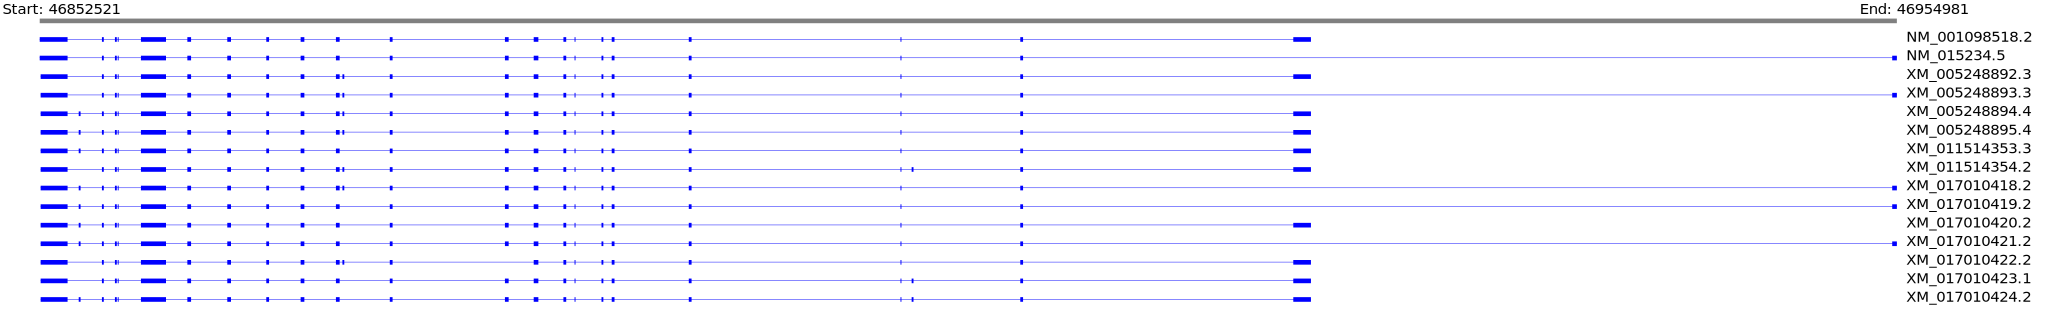

In [6]:
import svgwrite  

ref_gene_id = "ADGRF5"
cur = con.cursor()
statement = "SELECT DISTINCT t2.gene_id, t2.gene_name,t2.transcript_id,t2.ref_gene_id FROM transcripts as t, transcripts as t2 WHERE t.gene_id=t2.gene_id AND t.ref_gene_id=?"
res = cur.execute(statement, (ref_gene_id,))
df = pd.DataFrame(res.fetchall())
transcripts = df[2].to_list()

print("--Generate png--")
con = create_connection("../analysis/stringtie.db")
cur = con.cursor()
    
#go through transcript and get start first exon = start_genomic_region and last exon = end_genomic_region
start_genomic_region = float("inf")
end_genomic_region = 0
y = 0
for transcript in transcripts:
    y += 20
    statement = "SELECT e.start, e.end from has_exon as h, transcripts as t, exons as e WHERE e.id=h.exon AND h.transcript==t.id and t.transcript_id==?"
    res = cur.execute(statement, (transcript,))
    exons = res.fetchall()
    if (exons[0][0]) < start_genomic_region:
        start_genomic_region = exons[0][0]
    if (exons[-1][1]) > end_genomic_region:
        end_genomic_region = exons[-1][1]
    absolut = end_genomic_region-start_genomic_region

#draw for each transcript position in svg
size = 2000
d = svgwrite.Drawing(viewBox="0 0 "+ str(size+200) +" "+ str(y+50) +"", filename="Gene.svg")
    
y = 20
for transcript in transcripts:
    y += 20
    statement = "SELECT e.start, e.end, e.chrom, e.strand from has_exon as h, transcripts as t, exons as e WHERE e.id=h.exon AND h.transcript==t.id and t.transcript_id==?"
    res = cur.execute(statement, (transcript,))
    exons = res.fetchall()
    absolut = (end_genomic_region-start_genomic_region) #100%
    first_exon = float("inf")
    last_exon = 0
    for j in exons:
        start_exon = ((absolut-(end_genomic_region-j[0]))*size)//(absolut)
        end_exon = ((absolut-(end_genomic_region-j[1]))*size)//(absolut)
        if start_exon <first_exon:
            first_exon = start_exon
        if end_exon > last_exon:
            last_exon = end_exon
        exon = svgwrite.shapes.Rect(insert=(40+start_exon, y), size=((end_exon-start_exon), 5),fill='blue')
        d.add(exon)

    line = svgwrite.shapes.Rect(insert=(40+first_exon, y+2), size=(last_exon-first_exon, 0.5), fill='blue')
    d.add(line)
    transcript_id = svgwrite.text.Text(str(transcript), insert=(size+50,y+5))
    d.add(transcript_id)
        
    chrom = exons[0][2]
    strand = exons[0][3]

# mutation_position = ((absolut-(end_genomic_region-position_mut))*size)//(absolut)
# mutation = svgwrite.shapes.Rect(insert=(40+mutation_position, 20), size=(1,y), fill='red')

genomic_region = svgwrite.shapes.Rect(insert=(40, 20), size=(size, 5),fill='grey')

start = svgwrite.text.Text("Start: "+str(start_genomic_region), insert=(0,15))
end = svgwrite.text.Text("End: "+str(end_genomic_region), insert=(size,15))
    
d.add(genomic_region)
# d.add(mutation)
d.add(start)
d.add(end)
d.save()
    
# Draw a rectangle
# d.saveas(filename="test1.svg")
d  # Display as SVG

# Predict ORFs 

. for each transcript </br>
... Exon 1 start genompos end genomposit </br>
... Get ORF start und ende längstens ORF (position in cDNA 1...n) </br>
... Translate position in der cDNA zur position im Genom </br>
> vlt anhand von exon liste
> exon 1: 20400 20500, 1 100
> exon 2: 20600 20800, 1001, 1201
> demnach: wenn ORF 8, 1100 ist dann

Go through exon list, vor start look in with exon, and for end, then take von start pos exon also 1200-1001 =199, add that to start genomic, now you have position of Genom</br>

In [7]:
seq = "MDLKTVLSLPRYPGEFLHPVVYACTAVMLLCLLASFVTYIVHQSAIRISRKGRHTLLNFCFHAALTFTVFAGGINRTKYPILCQAVGIVLHYSTLSTMLWIGVTARNIYKQVTKKAPLCLDTDQPPYPRQPLLRFYLVSGGVPFIICGVTAATNIRNYGTEDEDTAYCWMAWEPSLGAFYGPAAIITLVTCVYFLGTYVQLRRHPGRRYELRTQPEEQRRLATPEGGRGIRPGTPPAHDAPGASVLQNEHSFQAQLRAAAFTLFLFTATWAFGALAVSQGHFLDMVFSCLYGAFCVTLGLFVLIHHCAKREDVWQCWWACCPPRKDAHPALDANGAALGRAACLHSPGLGQPRGFAHPPGPCKMTNLQAAQGHASCLSPATPCCAKMHCEPLTADEAHVHLQEEGAFGHDPHLHGCLQGRTKPPYFSRHPAEEPEYAYHIPSSLDGSPRSSRTDSPPSSLDGPAGTHTLACCTQGDPFPMVTQPEGSDGSPALYSCPTQPGREAALGPGHLEMLRRTQSLPFGGPSQNGLPKGKLLEGLPFGTDGTGNIRTGPWKNETTV"

In [4]:
560*3+(3) #plus stopp codon

1683

In [10]:
start_on_ORF = 23*3
end_on_ORF = 203*3

In [16]:
orf = "ATGGATCTGAAGACAGTGCTCTCCCTGCCCCGCTACCCAGGGGAGTTCCTGCACCCCGTGGTGTACGCGTGCACGGCCGTCATGCTGCTCTGCCTCCTGGCCTCCTTCGTCACCTACATCGTGCACCAGAGCGCCATCCGCATCAGCCGCAAGGGCCGGCACACGCTCCTGAATTTCTGCTTCCACGCGGCCCTGACCTTCACTGTGTTCGCCGGCGGCATCAATCGCACCAAGTACCCCATCCTGTGCCAGGCGGTGGGCATCGTGCTGCACTATTCTACACTGTCCACCATGCTGTGGATAGGAGTGACCGCCAGGAACATCTACAAGCAGGTGACCAAGAAGGCCCCTCTGTGCCTGGACACAGACCAGCCACCGTACCCCAGGCAGCCCCTGCTCAGGTTTTACCTCGTCAGCGGAGGGGTCCCCTTTATCATCTGTGGGGTCACGGCTGCCACGAACATCAGGAATTACGGGACAGAGGACGAGGACACGGCGTACTGCTGGATGGCCTGGGAGCCCAGCCTGGGCGCCTTCTACGGCCCAGCCGCCATCATCACCCTGGTCACCTGTGTGTACTTCCTGGGCACCTACGTGCAGCTGCGGCGCCACCCAGGGCGCAGGTACGAGCTGCGCACACAGCCCGAGGAGCAGCGGCGGCTGGCGACACCCGAGGGCGGCCGTGGGATCCGGCCAGGCACCCCACCCGCACACGATGCCCCCGGCGCCTCCGTGCTGCAGAACGAGCACTCATTCCAGGCACAGCTGCGCGCCGCCGCCTTCACGCTGTTCCTGTTCACGGCCACGTGGGCCTTCGGGGCGCTGGCGGTGTCACAGGGCCACTTCCTGGACATGGTCTTCAGCTGCCTGTACGGCGCCTTCTGCGTGACCCTGGGACTCTTCGTGCTCATCCACCACTGCGCCAAGCGTGAGGACGTGTGGCAGTGCTGGTGGGCATGCTGCCCGCCCCGCAAGGACGCCCACCCCGCACTTGACGCCAACGGGGCCGCGCTGGGCCGCGCCGCCTGCCTGCACTCGCCGGGACTGGGCCAGCCACGGGGCTTCGCGCACCCACCGGGCCCCTGCAAGATGACCAACCTGCAGGCCGCGCAGGGCCACGCCAGTTGCCTGTCACCGGCCACCCCGTGCTGCGCCAAGATGCACTGCGAGCCACTGACGGCGGACGAGGCGCACGTGCACCTGCAGGAGGAGGGCGCCTTCGGGCACGACCCCCACCTGCACGGGTGCCTTCAGGGCAGAACTAAGCCGCCCTACTTTAGCCGGCACCCAGCAGAGGAGCCCGAGTACGCCTACCACATCCCATCCAGCCTGGATGGCAGCCCCCGCAGCTCGCGCACAGACAGCCCCCCCAGCTCTCTGGATGGCCCGGCGGGGACACACACGCTGGCCTGCTGCACCCAGGGCGACCCCTTCCCCATGGTCACCCAGCCCGAGGGCAGTGATGGGAGCCCTGCCCTCTACAGCTGCCCCACGCAGCCGGGCAGGGAGGCAGCGCTCGGGCCCGGCCACTTGGAGATGCTGCGGAGGACACAGTCCCTGCCCTTTGGTGGCCCCAGCCAGAACGGGCTGCCCAAGGGTAAATTGCTAGAAGGCCTGCCGTTTGGCACCGACGGGACCGGCAACATCCGAACGGGACCCTGGAAAAACGAAACTACTGTGTAG"
len(orf)
len(orf[start_on_ORF:end_on_ORF]) #hier liegt die domaine im ORF

start_on_ORF+start

540

### Old

In [ ]:
def get_longest_ORF(cDNA, strandness):
    orf_list = find_orfs_with_trans(cDNA, 100, strandness)
    for length, start, end, strand, pro in orf_list:
        print(
            "%s...%s - length %i, strand %i, %i:%i, %i"
            % (pro[:30], pro[-3:], length, strand, start, end, len(pro))
        )

    return orf_list[0]

def find_orfs_with_trans(seq, min_protein_length, strandness):
    answer = []
    seq_len = len(seq)
    if strandness == "+":
        strand_an_nuc = (+1, Seq(seq))
    elif strandness == "-":
        strand_an_nuc = (-1, Seq(seq).reverse_complement())
            
    for strand, nuc in [strand_an_nuc]:
         for frame in range(3):
            trans = nuc[frame:].translate(1)
            trans_len = len(trans)
            aa_start = 0
            aa_end = 0
            while aa_start < trans_len:
                aa_end = trans.find("*", aa_start)
                if aa_end == -1:
                    aa_end = trans_len
                if aa_end - aa_start >= min_protein_length:
                    if strand == 1:
                        start = frame + aa_start * 3
                        end = min(seq_len, frame + aa_end * 3 + 3)
                    else:
                        start = seq_len - frame - aa_end * 3 - 3
                        end = seq_len - frame - aa_start * 3
                    answer.append((end-start, start, end, strand, nuc[start:end]))
                aa_start = aa_end + 1
    answer.sort(reverse=True)
    return answer


# Get motifs from uniprot

In [4]:
from unipressed import UniprotkbClient, UniparcClient
import xml.etree.ElementTree as ET
from Bio.Seq import Seq

In [19]:
# url = 'https://rest.uniprot.org/uniprotkb/search?compressed=true&fields=accession%2Creviewed%2Cid%2Cprotein_name%2Cgene_names%2Corganism_name%2Clength&format=tsv&query=%28%28gene%3AADGRA2%29%20AND%20%28taxonomy_id%3A9606%29%20AND%20%28keyword%3AKW-9994%29%29&size=500'
# response = requests.get(url)
# print(response.text)
gene = "ADGRA2"
api_domains = "https://rest.uniprot.org/uniprotkb/search?fields=ft_domain&sequence&format=tsv&query=%28%28gene%3A{}%29%20AND%20%28taxonomy_id%3A9606%29%29".format(gene)
api_sequence = "https://rest.uniprot.org/uniprotkb/search?fields=sequence&format=tsv&query=%28%28gene%3A{}%29%20AND%20%28taxonomy_id%3A9606%29%29".format(gene)
response = requests.get(api_sequence)
first_result = response.text.split("\n")[1:]#get first entry
protein = ""
for i in first_result:
    protein += i
print(protein)

response = requests.get(api_domains)
print(response.text)
first_result = response.text.split("\n")[1]#get first entry
domains = first_result.split("DOMAIN")[1:]
print(domains)

# print()
# print(domains[1:])

api_domains = "https://rest.uniprot.org/uniprotkb/search?fields=ft_domain&sequence&format=xml&query=%28%28gene%3A{}%29%20AND%20%28taxonomy_id%3A9606%29%29".format(gene)
response = requests.get(api)
root = ET.fromstring(response.content)

# for child in root.iter('*'):
#     if (child.tag=="{http://uniprot.org/uniprot}sequence"):
#         if child.text!=None:
#             print(child.text)
#             print(child.attrib["length"])

MGAGGRRMRGAPARLLLPLLPWLLLLLAPEARGAPGCPLSIRSCKCSGERPKGLSGGVPGPARRRVVCSGGDLPEPPEPGLLPNGTVTLLLSNNKITGLRNGSFLGLSLLEKLDLRNNIISTVQPGAFLGLGELKRLDLSNNRIGCLTSETFQGLPRLLRLNISGNIFSSLQPGVFDELPALKVVDLGTEFLTCDCHLRWLLPWAQNRSLQLSEHTLCAYPSALHAQALGSLQEAQLCCEGALELHTHHLIPSLRQVVFQGDRLPFQCSASYLGNDTRIRWYHNRAPVEGDEQAGILLAESLIHDCTFITSELTLSHIGVWASGEWECTVSMAQGNASKKVEIVVLETSASYCPAERVANNRGDFRWPRTLAGITAYQSCLQYPFTSVPLGGGAPGTRASRRCDRAGRWEPGDYSHCLYTNDITRVLYTFVLMPINASNALTLAHQLRVYTAEAASFSDMMDVVYVAQMIQKFLGYVDQIKELVEVMVDMASNLMLVDEHLLWLAQREDKACSRIVGALERIGGAALSPHAQHISVNARNVALEAYLIKPHSYVGLTCTAFQRREGGVPGTRPGSPGQNPPPEPEPPADQQLRFRCTTGRPNVSLSSFHIKNSVALASIQLPPSLFSSLPAALAPPVPPDCTLQLLVFRNGRLFHSHSNTSRPGAAGPGKRRGVATPVIFAGTSGCGVGNLTEPVAVSLRHWAEGAEPVAAWWSQEGPGEAGGWTSEGCQLRSSQPNVSALHCQHLGNVAVLMELSAFPREVGGAGAGLHPVVYPCTALLLLCLFATIITYILNHSSIRVSRKGWHMLLNLCFHIAMTSAVFAGGITLTNYQMVCQAVGITLHYSSLSTLLWMGVKARVLHKELTWRAPPPQEGDPALPTPSPMLRFYLIAGGIPLIICGITAAVNIHNYRDHSPYCWLVWRPSLGAFYIPVALILLITWIYFLCAGLRLRGPLAQNPKAGNSRASLEAGEELRGSTRLRGSGPLLSDSGSLLATGSARV

In [32]:
service = UniProt() # it is good practice to have a meaningful variable name
# Build a query string
query = "ADGRA1"

# Send the query to UniProt, and catch the search result in a variable
result = service.search(query)

# Inspect the resultb
print(result)

Entry	Entry Name	Reviewed	Protein names	Gene Names	Organism	Length
Q86SQ6	AGRA1_HUMAN	reviewed	Adhesion G protein-coupled receptor A1 (G-protein coupled receptor 123)	ADGRA1 GPR123 KIAA1828	Homo sapiens (Human)	560
Q8C4G9	AGRA1_MOUSE	reviewed	Adhesion G protein-coupled receptor A1 (G-protein coupled receptor 123)	Adgra1 Gpr123	Mus musculus (Mouse)	578
Q6PHM3	Q6PHM3_MOUSE	unreviewed	Gpr123 protein	Adgra1 Gpr123	Mus musculus (Mouse)	618
Q76JQ1	Q76JQ1_MOUSE	unreviewed	MKIAA1828 protein	Adgra1 Gpr123 mKIAA1828	Mus musculus (Mouse)	587
A0A7L4JLA3	A0A7L4JLA3_9AVES	unreviewed	AGRA1 protein	Adgra1 CEUAER_R05217	Ceuthmochares aereus	723
E1BCW2	E1BCW2_BOVIN	unreviewed	Adhesion G protein-coupled receptor A1	ADGRA1	Bos taurus (Bovine)	569
A0A0G2K4I3	A0A0G2K4I3_RAT	unreviewed	Adhesion G protein-coupled receptor A1	Adgra1	Rattus norvegicus (Rat)	577
F7D5A1	F7D5A1_HORSE	unreviewed	Adhesion G protein-coupled receptor A1	ADGRA1	Equus caballus (Horse)	566
A0A286ZYZ3	A0A286ZYZ3_PIG	unreviewed	Adhesion G 

In [15]:
def find_protein_domains(protein_name):
    # First, we need to install and import the requests library
    
    protein_accession = get_protein_accession_by_protein_name(protein_name)
    # Next, we can use the UniProt REST API to search for the protein sequence and domains of the protein
    query_url = 'https://www.uniprot.org/uniprot/?query=name:{}&format=tab&columns=sequence,feature(DOMAIN%20EXTENT)'.format(protein_accession)
    
    response = requests.get(query_url)
    if response.status_code != 200:
        print(response.status_code)
        print(response.text)    
    results = response.text.strip().split('\n')[1:]
  
    print(results)
    # Extract the protein sequence and list of domains and their positions from the results
    protein_sequence = results[0].split('\t')[0]
    domains = []
    for result in results:
        domain_data = result.split('\t')[1]
    if domain_data:
        domain, start, end = domain_data.split(' ')
        domains.append({'domain': domain, 'start': start, 'end': end})
  
    # Return the protein sequence and list of domains and their positions that were found
    return {'sequence': protein_sequence, 'domains': domains}

print(find_protein_domains("ADGRA1"))

400
{"url":"http://rest.uniprot.org/uniprotkb/query=protein_name:ADGRA1&amp;format=tab&amp;columns=id","messages":["The 'accession' value has invalid format. It should be a valid UniProtKB accession"]}
{"url":"http://rest.uniprot.org/uniprotkb/query=protein_name:ADGRA1&amp;format=tab&amp;columns=id","messages":["The 'accession' value has invalid format. It should be a valid UniProtKB accession"]}


NameError: name 'accession_number' is not defined

In [14]:
def get_protein_accession_by_protein_name(protein_name):
    query_url = "https://rest.uniprot.org/uniprotkb/search?fields="
    
    query_url = 'https://www.uniprot.org/uniprot/?query=protein_name:{}&format=tab&columns=id'.format(protein_name)
    response = requests.get(query_url)
    if response.status_code != 200:
        print(response.status_code)
        print(response.text) 
    print(response.text)
    
    return accession_number

## get domains from domain.tsv

In [55]:
#create new dataframe with two columns  "protein" and "sequence"
df_proteins = pd.DataFrame(columns=["transcript", "sequence"])

#open file and read each line
with open("../scripts/results/cDNA.fasta") as f:
    for line in f:
        if line.startswith(">"):
            transcript = line.lstrip(">").rstrip()
            # add new row to dataframe
            df_proteins = df_proteins.append({"transcript": transcript, "sequence": ""}, ignore_index=True)
        else:
            df_proteins.loc[df_proteins['transcript'] == transcript, 'sequence'] = line.rstrip()
print(df_proteins)


# read tsv file and save as pandas dataframe
df = pd.read_csv("../scripts/results/domains.tsv", sep="\t", header=None)
#sort pandas dataframe by third row
df = df.sort_values(by=[2], ascending=False)
df.drop([1,3,4,8,9,10,11], axis=1, inplace=True)

#get first row of df
longest_transcript = df.iloc[0,0]
print(longest_transcript)
#get all rows with longest transcript
df = df.loc[df[0] == longest_transcript]
df
# iter through df and get start and end of each domain
for index, row in df.iterrows():
    domain = row[5]
    start = row[6]
    end = row[7]
    print(domain, start*3, end*3)


# match start, end of domain to protein sequence
# get protein sequence



        transcript                                           sequence
0    MSTRG.52975.5  GCGGCGGCGGCAGCAGGAGCCCGGCGCGATCCGCTAGGTCCCAGCC...
1    MSTRG.52975.5  GCGGCGGCGGCAGCAGGAGCCCGGCGCGATCCGCTAGGTCCCAGCC...
2    MSTRG.52975.6  CTCAGCTCACTGCAACCTCCACCTCCCAGGTTCAGGGACCTGAGGA...
3    MSTRG.52975.5  GCGGCGGCGGCAGCAGGAGCCCGGCGCGATCCGCTAGGTCCCAGCC...
4    MSTRG.52975.6  CTCAGCTCACTGCAACCTCCACCTCCCAGGTTCAGGGACCTGAGGA...
5    MSTRG.52975.7  GGAGATCGTGGTGCTGGAGACCTCTGCCTCCTACTGCCCCGCCGAG...
6    MSTRG.52975.5  GCGGCGGCGGCAGCAGGAGCCCGGCGCGATCCGCTAGGTCCCAGCC...
7    MSTRG.52975.6  CTCAGCTCACTGCAACCTCCACCTCCCAGGTTCAGGGACCTGAGGA...
8    MSTRG.52975.7  GGAGATCGTGGTGCTGGAGACCTCTGCCTCCTACTGCCCCGCCGAG...
9     NM_032777.10  ATCCATGGCACGGAGCGGCGGCGGCGGCGGCAGCAGGAGCCCGGCG...
10   MSTRG.52975.5  GCGGCGGCGGCAGCAGGAGCCCGGCGCGATCCGCTAGGTCCCAGCC...
11   MSTRG.52975.6  CTCAGCTCACTGCAACCTCCACCTCCCAGGTTCAGGGACCTGAGGA...
12   MSTRG.52975.7  GGAGATCGTGGTGCTGGAGACCTCTGCCTCCTACTGCCCCGCCGAG...
13    NM_032777.10  

# 2022-12-12  second try - Transcript variants of all adhesian GPCRs

## Data - add new dataset

- GSE101521
- GSE217427
- SRP302848
- SRP225193
- Gide 

In each folder:
```cat SRR_list.txt | xargs -n 1 bash ../../analysis/get_SRR_data.sh```

## Analysis

###  Mapping and Quantification (STAR, Stringite)

in each folder: ``` ../../analysis/splice_variants_analysis.sh```

###  Merge gtf files then re-Quantification (Stringtie)

old data:

    GSE173955_Alzheimer
    GSE182321_OpiodUseDisorder
    GSE174478_Non_alcoholic_fatty_liver

create file with name of all dirs:

    SRP225193_many_tissues
    GSE217427_kidney
    GSE101521_brain
    GSE165303_SRP302848_heart
    melanoma_Gide
    
```shell
OUTPUT="/home/christina/Transcript_Variants_aGPCR/analysis/SRP225193_many_tissues"
ls ${OUTPUT}/stringtie/*.gtf >> mergefile.txt

OUTPUT="/home/christina/Transcript_Variants_aGPCR/analysis/GSE217427_kidney"
ls ${OUTPUT}/stringtie/*.gtf >> mergefile.txt

OUTPUT="/home/christina/Transcript_Variants_aGPCR/analysis/GSE165303_SRP302848_heart"
ls ${OUTPUT}/stringtie/*.gtf >> mergefile.txt

OUTPUT="/home/christina/Transcript_Variants_aGPCR/analysis/melanoma_Gide"
ls ${OUTPUT}/stringtie/*.gtf >> mergefile.txt
```

create a new merge file with all gtfs from new mapped datasets and merge with gtf of old combo.gtf file

```shell
stringtie --merge -G combo_old.gtf -o /home/christina/Transcript_Variants_aGPCR/analysis/combo_new.gtf mergefile.txt -l "NSTRG";
```
did not work!

we need to take combo_old.gtf as a file like all the others in mergefile.txt

```shell
stringtie --merge -G §ANNO -o /home/christina/Transcript_Variants_aGPCR/analysis/combo_version2.gtf mergefile.txt -l "NSTRG";
```

and re-quantify

```./stringtie_expression_estimation.sh directories.txt``` 

### Create database and add tissue, organisms information

pheno_data.csv
EXMAPLE:
```
id,condition
SRR14436589,alzheimer
SRR14436590,alzheimer
SRR14436591,alzheimer
SRR14436592,alzheimer
SRR14436593,alzheimer
SRR14550955,liver
SRR14550956,liver
SRR14550957,liver
SRR14550958,liver
```

# New database created -> Include domain information

## search for all transcript in pfam database for domains and create table in stringtie_2.db with all domains

- script all_protein.py erstellt protein.fasta
- damit dann interproscan
- dann hier domänen in database einfügen

In [3]:
import os
def find_longest_ORF(cDNA, strandness, transcript):
    '''
    Get start and stop postition of longest ORF in cDNA
    Checks if gene comes from + or - strand
    :param DNA, strandness
    :return start_pos, stop_position <- on cDNA on original genomic direction, orf_sequence, protein_sequence
    '''
    # print("--Find ORFs of ",transcript,"--")
    originalcDNA = cDNA #make a copy of DNA
    start = 0
    ORFs = [] #list with all ORFs and start and end position

    # if strand is minus, take the reverse complement if the cDNA 
    # in order to search for the longest ORF
    if strandness == "-":
        cDNA = str(Seq(cDNA).reverse_complement())
        
    # print("cDNA:", cDNA)
    # print("originalcDNA:", originalcDNA)
    if 'ATG' in cDNA:
        for startMatch in re.finditer('ATG',cDNA): #check if substring starts with ATG
            remaining = cDNA[startMatch.start():]
            for stopMatch in re.finditer('TAA|TGA|TAG', remaining): #check for substring ending with stopcodons
                substring = remaining[:stopMatch.end()]
                if len(substring) % 3 == 0: #check if triplets
                    start = startMatch.start() #get start position in cDNA or if "-" on reverse complement cDNA
                    end = start+(len(substring)) #get end position start+len()-1
                    ORFs.append([substring,start,end]) #add ORF and start and end position to list
                    break #break when first stop codon is seen
    
    #sort list of lists [[ORF,start,stop],...] by len of first element
    ORFs = sorted(ORFs, key=lambda x: len(x[0]), reverse=True)
    # print(ORFs[0][0][0:10], len(ORFs[0][0]), ORFs[1][0][0:10], len(ORFs[1][0]), ORFs[2][0][0:10], len(ORFs[2][0]))
    
    if len(ORFs)==0:
        return (0, 0, "No ORF found", None)
    
    longest = ORFs[0] # save first item in list as longest ORF
    # match the start and stop position of the ORF on the original cDNA
    if strandness == "-": #if strand is minus, get original positions on + strand
        start_pos = (len(originalcDNA)-1)-longest[2]
        end_pos = (len(originalcDNA)-1)-longest[1]
    else:
        start_pos = longest[1]
        end_pos = longest[2]

    #only the longest ORF to file
    # with open("longest_ORF.fasta","a") as f:
    #     if len(ORFs)>=1:
    #         f.write(">"+transcript+"\n"+str(ORFs[0][0])+"\n")
    # f.close()

    # #write proteins to file
    # with open("proteins.fasta","a") as f: 
    #     if len(ORFs)>=1:
    #         cDNA_Seq = Seq(ORFs[0][0])
    #         protein = cDNA_Seq.translate(to_stop=True, cds=True)
    #         f.write(">"+transcript+"\n"+str(protein)+"\n")
    # f.close()

    if len(ORFs)>=1:
        cDNA_Seq = Seq(ORFs[0][0])
        protein = cDNA_Seq.translate(to_stop=True, cds=True)
    
    return (start_pos, end_pos, longest[0], str(protein))

In [5]:
# create table domains (transcript text, domain text, start int, end int)
import sqlite3
import pandas as pd
import pybedtools
from Bio.Seq import Seq
import regex as re
import subprocess
import os
con = sqlite3.connect("../analysis/stringtie_2.db")
cur = con.cursor()

try:
    df_domains = pd.read_csv("all_domains.tsv", sep="\t", header=None) 
    df_domains.drop([1,2,3,4,8,9,10,11,12], axis=1, inplace=True)
    df_domains.columns=["transcript", "domain", "start", "end"]
except:
    print("no domain found")

print(df_domains.head())

cur.execute("SELECT * FROM transcripts")
transcripts = cur.fetchall()
for transcript in transcripts:
    statement = "SELECT e.chrom, e.start, e.end, e.strand, t.transcript_id, t.id from transcripts as t, exons as e WHERE e.transcript==t.id AND t.id==?"
    cur.execute(statement, (transcript[0],))
    #get cDNA sequence of transcript
    cDNA_transcript=""
    #write bed file with exons
    df = pd.DataFrame(cur.fetchall())
    df.columns=["chromosom", "start", "end", "strand", "transcript_id","id"]
    #take only first 3 columns
    df_bed = df.iloc[:,0:3]
    #safe tmp bed file
    df_bed.to_csv("gene.bed",sep="\t", index=False, header=False)
    gene_bed = pybedtools.BedTool("gene.bed")
    fasta = pybedtools.BedTool("hg38.fna")
    a = gene_bed.sequence(fi=fasta)
    with open(a.seqfn) as f:
        for line in f:
            if not(line.strip().startswith(">")):
                cDNA_transcript += line.strip()
    f.close()
    cDNA_transcript += cDNA_transcript
    #get longest ORF of cDNA sequence
    start, stop, longest, protein = find_longest_ORF(cDNA_transcript,df["strand"][0],df["transcript_id"][0])

    if longest == "No ORF found":
        continue

    #get all rows in df_domain where transcript_id == transcript
    df_domains_for_transcript = df_domains[df_domains["transcript"]==df["transcript_id"][0]]

    #if df_domains_for_transcript is empty, continue
    if df_domains_for_transcript.empty:
        continue
    
    print("Transcript:", df["transcript_id"][0], " with id: ", df["id"][0])
    print(df_domains_for_transcript)

    #for each domain in database 
    for index, row in df_domains_for_transcript.iterrows():
        domain = row["domain"]
        #clean domain string from unwanted characters
        domain = re.sub(r'\(.*?\)', '', domain)
        print(domain)
        start_domain_on_ORF = row["start"]*3
        end_domain_on_ORF = row["end"]*3

        #find the position of the ORF in the cDNA
        start_ORF_on_cDNA = cDNA_transcript.find(longest)
        #now i have start and end of the ORF in the cDNA 
        #but i need the start and end of the domain on the cDNA
        # so i use the start of the ORF + the start of the domain on the ORF
        start_on_cDNA = start_ORF_on_cDNA + start_domain_on_ORF
        end_on_cDNA = start_ORF_on_cDNA + end_domain_on_ORF

        # match the start and stop position of the domain on the original cDNA
        if df["strand"][0] == "-": #if strand is minus, get original positions on + strand
            start_pos = (len(cDNA_transcript)-1)-end_on_cDNA
            end_pos = (len(cDNA_transcript)-1)-start_on_cDNA
        else:
            start_pos = start_on_cDNA
            end_pos = end_on_cDNA

        # print(domain, start_pos, end_pos)
        #save domains in databa
        print(int(df["id"][0]))
        statement = "INSERT INTO domains (transcript, domain, start, end) VALUES (?,?,?,?)"
        try:
            cur.execute(statement, (int(df["id"][0]), domain, start_pos, end_pos))
            con.commit()
        except:
            print("Domain already exists")

       transcript                           domain  start   end
0  XM_024446780.1      Immunoglobulin I-set domain    465   542
1  XM_024446780.1      Immunoglobulin I-set domain    548   633
2  XM_024446780.1  Bravo-like intracellular region   1086  1120
3  XM_024446780.1      Fibronectin type III domain    649   733
4  XM_024446780.1      Fibronectin type III domain    953  1037
Transcript: NSTRG.4.3  with id:  8
       transcript                       domain  start  end
105980  NSTRG.4.3  WAHD domain of WASH complex    122  253
105981  NSTRG.4.3  WAHD domain of WASH complex      3   73
WAHD domain of WASH complex
8
WAHD domain of WASH complex
8
Transcript: NSTRG.4.4  with id:  9
       transcript                       domain  start  end
277264  NSTRG.4.4  WAHD domain of WASH complex     13  121
WAHD domain of WASH complex
9
Transcript: NSTRG.4.5  with id:  10
       transcript                       domain  start  end
434612  NSTRG.4.5  WAHD domain of WASH complex      3   91
WAHD do

KeyboardInterrupt: 

In [14]:
def get_start_and_end_genomic_region(transcripts):
    """ get start and end of genomic region
    :param transcripts: list of transcripts
    :return: start_genomic_region, end_genomic_region, y
    """
    #open database connection
    con = create_connection("../analysis/stringtie_2.db")
    cur = con.cursor()

    #initialize start and end of genomic region
    start_genomic_region = float("inf")
    end_genomic_region = 0
    y = 0
    #go through transcript and get start first exon = start_genomic_region and last exon = end_genomic_region
    for transcript in transcripts:
        y += 20
        statement = statement = "SELECT e.start, e.end from transcripts as t, exons as e WHERE e.transcript==t.id and t.transcript_id==?"
        res = cur.execute(statement, (transcript,))
        exons = res.fetchall()
        if (exons[0][0]) < start_genomic_region:
            start_genomic_region = exons[0][0]
        if (exons[-1][1]) > end_genomic_region:
            end_genomic_region = exons[-1][1]
    return start_genomic_region, end_genomic_region, y

get_start_and_end_genomic_region(['NM_001083909.2', 'NM_001291085.1', 'NSTRG.11839.1', 'NSTRG.11839.6', 'XM_011540273.1', 'XM_017016779.1'])

[(133088003, 133088138), (133088707, 133088912), (133096973, 133097101), (133098639, 133098763), (133102696, 133102842), (133127232, 133127331), (133128328, 133131699)]
[(133102245, 133102338), (133102696, 133102842), (133127232, 133127331), (133128328, 133131699)]
[(133086591, 133088138), (133088707, 133088912), (133096973, 133097101), (133098639, 133102338), (133102696, 133102842), (133127232, 133127331), (133128328, 133131699)]
[(133130195, 133130537), (133131268, 133131699)]
[(133098694, 133098763), (133127232, 133127331), (133128328, 133131699)]
[(133088712, 133088912), (133096973, 133097101), (133098639, 133098763), (133102696, 133102842), (133105016, 133107969)]


(133086591, 133131699, 120)

In [19]:
con = create_connection("../analysis/stringtie_2.db")
cur = con.cursor()
tissues  = set()
res = cur.execute("SELECT DISTINCT tissue FROM samples")
res.fetchall()
# tissues = list(set([item[0] for item in res.fetchall()]))
    
# tissues_and_samples = tissues + samples
# tissues_and_samples = [{"label":i, "value":i} for i in tissues_and_samples]
# con.close()

[(None,)]

# TMP Cutoff für Torsten

check a TPM cutoff for saturation of a extracted mRNA 
and how many reads per sample <br>

TODO:

- for each sample in db, get median TPM for all transcripts 
- then over all samples average

In [21]:
import pandas as pd
con = create_connection("stringtie_2.db")
cur = con.cursor()
statement = """WITH temp_sample_averages AS (
    SELECT expresses.transcript, expresses.sample, AVG(expresses.tpm) AS sample_avg
    FROM expresses
    WHERE expresses.sample IN (188,92, 33)
    GROUP BY expresses.transcript, expresses.sample
)
SELECT transcripts.transcript_id, AVG(sample_avg) AS average_tpm
FROM temp_sample_averages
INNER JOIN transcripts ON transcripts.id = temp_sample_averages.transcript
GROUP BY transcripts.transcript_id;"""
res = cur.execute(statement)
samples = pd.DataFrame(res.fetchall())
print(len(samples))

402472


In [22]:
print(len(samples))
#average of column 1
print(samples[1].mean())
#standard deviation of column 1
print(samples[1].std())

402472
2.484644860858872
243.1181603947852


In [23]:
#delete all rows where column 0 includes "NSTRG"
samples = samples[~samples[0].str.contains("NSTRG")]
print(len(samples))
print(len(samples))
#average of column 1
print(samples[1].mean())
#standard deviation of column 1
print(samples[1].std())

166577
166577
4.96267117287447
375.27142871746395


In [34]:
con = create_connection("stringtie_2.db")
cur = con.cursor()
statement = "SELECT id, name from samples"
res = cur.execute(statement)
samples = pd.DataFrame(res.fetchall())
print(len(samples))

i=0
for sample_name in samples.iterrows():
    #für jede id also jedes sample 
    # berechne mean of all transcript
    sample_id = str(sample_name[0])
    print(sample_id)
    cur = con.cursor()
    statement = "SELECT samples.id, samples.name, transcripts.transcript_id, avg(expresses.tpm) FROM expresses, samples, transcripts WHERE samples.id==? and transcripts.id==expresses.transcript and expresses.sample==samples.id GROUP BY expresses.transcript"
    res = cur.execute(statement, sample_id)
    result = pd.DataFrame(res.fetchall())
    if not result.empty:
        print(result)

927
0
1
        0              1               2         3
0       1  ipiPD1_10_PRE       NSTRG.1.1  0.000000
1       1  ipiPD1_10_PRE       NSTRG.2.1  0.000000
2       1  ipiPD1_10_PRE       NSTRG.3.1  2.080581
3       1  ipiPD1_10_PRE     NR_046018.2  0.000000
4       1  ipiPD1_10_PRE       NSTRG.3.3  0.000000
...    ..            ...             ...       ...
402467  1  ipiPD1_10_PRE  XR_002959225.1  0.000000
402468  1  ipiPD1_10_PRE  XR_002959224.1  0.000000
402469  1  ipiPD1_10_PRE  XR_002959223.1  0.000000
402470  1  ipiPD1_10_PRE     NR_031737.1  0.000000
402471  1  ipiPD1_10_PRE   NR_039661.1_2  0.000000

[402472 rows x 4 columns]
2


KeyboardInterrupt: 

In [4]:
con = create_connection("stringtie_2.db")
cur = con.cursor()
statement = """
    SELECT transcripts.transcript_id, AVG(sample_avg) AS average_tpm
    FROM (
        SELECT expresses.transcript, expresses.sample, AVG(expresses.tpm) AS sample_avg
        FROM expresses
        GROUP BY expresses.transcript, expresses.sample
    ) AS sample_averages
    INNER JOIN transcripts ON transcripts.id = sample_averages.transcript
    GROUP BY transcripts.transcript_id
"""
res = cur.execute(statement)
result = pd.DataFrame(res.fetchall())

In [30]:
import csv
from collections import defaultdict

# Specify the input file path
gtf_file_path = "GSE101521_brain/ballgown_redone_2/SRR5831944/SRR5831944.gff"
# Define the column names for the GTF file
column_names = ['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute']

# Read the GTF file into a DataFrame
df = pd.read_csv(gtf_file_path, sep='\t', comment='#', names=column_names)
#remove all entreies where feature == exon
df = df[df.feature != "exon"]
#delete seqname, source, score, frame, start, end, score, strand, frame columns and only keep attribute column, which will be split into multiple columns
df = df.drop(columns=['seqname', 'source', 'score', 'frame', 'start', 'end', 'score', 'strand', 'frame'])
df
#split attribute column into multiple columns, and take atributes key as name of the column, however some of them have not ref_gene_name, so we have to fill them with None
df = df.join(df['attribute'].str.split(';', expand=True).add_prefix('attribute_'))
df
#for all rows in df, 
for index, row in df.iterrows():
    #if column 5  not include "ref_gene_name" then fill it with None but take this column entrie and the next 2 and short all of them one column to the right
    if "ref_gene_name" not in row[4]:
        tmp = row[4]
        tmp_fkpm= row[5]
        tmp_tpm = row[6]
        row[4] = None
        row[5] = tmp
        row[6] = tmp_fkpm
        row[7] = tmp_tpm

#remove every column except of the columns 2,3,7 
df = df.drop(columns=['feature', 'attribute', 'attribute_2', 'attribute_3', 'attribute_4', 'attribute_6'])
# in column 2 remove the TPM and transform the column into float
# df['attribute_5'] = df['attribute_5'].str.replace('TPM', '').str.replace('"', '').astype(float)
# df
#for each row in df check if attribute_5 has the string FPKM in it, if yes print the row
for index, row in df.iterrows():
    if "FPKM" in row[2]:
        print(row)

attribute_0             gene_id "NSTRG.189"
attribute_1     transcript_id "XR_946835.1"
attribute_5                      FPKM "0.0"
Name: 4208594, dtype: object
attribute_0             gene_id "NSTRG.189"
attribute_1     transcript_id "XR_946836.1"
attribute_5                      FPKM "0.0"
Name: 4208598, dtype: object
attribute_0             gene_id "NSTRG.189"
attribute_1     transcript_id "XR_946838.1"
attribute_5                      FPKM "0.0"
Name: 4208603, dtype: object
attribute_0             gene_id "NSTRG.189"
attribute_1     transcript_id "XR_946839.1"
attribute_5                      FPKM "0.0"
Name: 4208607, dtype: object
attribute_0             gene_id "NSTRG.189"
attribute_1     transcript_id "XR_946840.1"
attribute_5                      FPKM "0.0"
Name: 4208611, dtype: object
attribute_0             gene_id "NSTRG.205"
attribute_1     transcript_id "NM_080431.5"
attribute_5                      FPKM "0.0"
Name: 4208620, dtype: object
attribute_0                gene_id

In [23]:
results = df.groupby(['attribute_0']).median()
results

KeyError: 0

# Covert searborn to plotly for using 

An error occurred while saving the heatmap: name 'BytesIO' is not defined


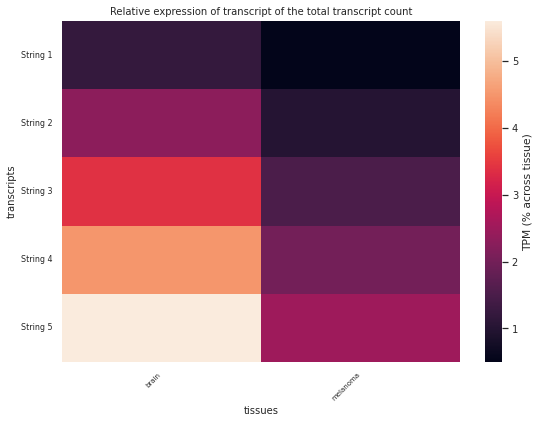

In [13]:
import seaborn as sns
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt

def generate_heatmap(tpms, transcripts, relative=True):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=0.9)

    if relative:
        cbar_legend = 'TPM (% across tissue)'
    else:
        cbar_legend = 'TPM (mean across tissue)'

    sns.heatmap(tpms, cbar=True, xticklabels=1, yticklabels=1, cbar_kws={'label': cbar_legend})

    if relative:
        plt.title('Relative expression of transcript of the total transcript count', fontsize=10)
    else:
        plt.title('Absolute expression of transcript', fontsize=10)

    plt.yticks(np.arange(len(transcripts)) + 0.5, transcripts, rotation=0, fontsize=8)
    plt.xticks(rotation=45, ha='right', fontsize=7)

    plt.xlabel('tissues', fontsize=10)
    plt.ylabel('transcripts', fontsize=10)

    plt.tight_layout()
    
    try:
        output = BytesIO()
        plt.savefig(output, dpi=300)
        heatmap_fig = px.imshow(output.getvalue())
        plt.clf()
        print(f"Heatmap created")
        # return output.getvalue()
        return heatmap_fig
    except Exception as e:
        print(f"An error occurred while saving the heatmap: {str(e)}")
    
    
# Create a dictionary with the column names as keys and the float numbers as values
tpms = {"brain": [1.2, 2.3, 3.4, 4.5, 5.6],
        "melanoma": [0.5, 1.0, 1.5, 2.0, 2.5]}
df = pd.DataFrame(tpms)

transcripts = ['String 1', 'String 2', 'String 3', 'String 4', 'String 5']

# Create the pandas series
series = pd.Series(transcripts)

generate_heatmap(df, series)
